In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('database1').getOrCreate()

24/11/23 22:28:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [59]:
#scikit-learn.org/stable
#pip install pyarrow
#pip install mlflow


import mlflow
import mlflow.xgboost

from pyspark.sql.types import IntegerType,DateType,StringType,StructType,StructField
from pyspark.sql.functions import avg,min,max,sum,col,mean,lit


from pyspark.ml.feature import StandardScaler,VectorAssembler,MinMaxScaler,StringIndexer, OneHotEncoder
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor

from pyspark.ml.regression import GBTRegressor
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import xgboost.spark as xgb

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import NaiveBayes

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics


In [4]:
sp_df = spark.read.format('csv').option('header',True).option('inferSchema',True).load('10_S&P500_Stock_Data.csv')

#### One Hot Encoding

In [5]:
titanic_df = (spark.read.format('csv')
           .option('header',True)
           .option('inferSchema',True)
           .load('10_titanic.csv'))

titanic_df.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [50]:
indexer = StringIndexer(inputCol="Sex", outputCol="Sex_index")
df_indexed = indexer.fit(titanic_df).transform(titanic_df)
encoder = OneHotEncoder(inputCol="Sex_index", outputCol="Sex_encoder")
df_encoded = encoder.fit(df_indexed).transform(df_indexed)
df_encoded.select('Sex','Sex_encoder').show()

+------+-------------+
|   Sex|  Sex_encoder|
+------+-------------+
|  male|(1,[0],[1.0])|
|female|    (1,[],[])|
|female|    (1,[],[])|
|female|    (1,[],[])|
|  male|(1,[0],[1.0])|
|  male|(1,[0],[1.0])|
|  male|(1,[0],[1.0])|
|  male|(1,[0],[1.0])|
|female|    (1,[],[])|
|female|    (1,[],[])|
|female|    (1,[],[])|
|female|    (1,[],[])|
|  male|(1,[0],[1.0])|
|  male|(1,[0],[1.0])|
|female|    (1,[],[])|
|female|    (1,[],[])|
|  male|(1,[0],[1.0])|
|  male|(1,[0],[1.0])|
|female|    (1,[],[])|
|female|    (1,[],[])|
+------+-------------+
only showing top 20 rows



#### Normalization

In [ ]:
assembler = VectorAssembler(inputCols = ['Interest Rates', 'Employment', 'S&P 500 Price'], outputCol = 'features')
df_vector = assembler.transform(sp_df)
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)
df_scaled.select('scaled_features').show(truncate=False)

#### Standadization 

In [ ]:
assembler = VectorAssembler(inputCols = ['Interest Rates', 'Employment', 'S&P 500 Price'], outputCol = 'features')
df_vector = assembler.transform(sp_df)
scalar = StandardScaler(inputCol = 'features',outputCol = 'scaled_features')
scaler_model = scalar.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)
df_scaled.select('scaled_features').show(truncate=False)

#### Supervised - Simple Linear Regression

In [91]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [6]:
icecream_df = (spark.read.format('csv')
           .option('header',True)
           .option('inferSchema',True)
           .load('11_IceCreamData.csv'))

##11_IceCreamData.csv

In [71]:
icecream_df.show(3)

+-----------+-----------+
|Temperature|    Revenue|
+-----------+-----------+
|24.56688442|534.7990284|
|26.00519115|625.1901215|
|27.79055388|660.6322888|
+-----------+-----------+
only showing top 3 rows



In [72]:
icecream_df.head(2)

[Row(Temperature=24.56688442, Revenue=534.7990284),
 Row(Temperature=26.00519115, Revenue=625.1901215)]

In [74]:
icecream_df.tail(2)

[Row(Temperature=22.36240237, Revenue=566.2173038),
 Row(Temperature=28.95773632, Revenue=655.6603879)]

In [75]:
icecream_df.columns

['Temperature', 'Revenue']

assembler = VectorAssembler(inputCols = ['Temperature'], outputCol = 'features')
df_assembler = assembler.transform(icecream_df)

train_df,test_df = df_assembler.randomSplit([0.8,0.2],seed = 12345)

lr = LinearRegression(featuresCol = 'features',labelCol = 'Revenue')

lr_model = lr.fit(train_df)

test_prediction = lr_model.transform(test_df)

test_prediction.show()

In [104]:
evaluator_rmse = RegressionEvaluator(labelCol = 'Revenue', predictionCol = 'prediction', metricName = 'rmse')
evaluator_r2 = RegressionEvaluator(labelCol = 'Revenue', predictionCol = 'prediction', metricName = 'r2')
evaluator_mae = RegressionEvaluator(labelCol = 'Revenue', predictionCol = 'prediction', metricName = 'mae')
rmsc = evaluator_rmse.evaluate(test_prediction)
r2 = evaluator_r2.evaluate(test_prediction)
mae = evaluator_mae.evaluate(test_prediction)
coefficients = lr_model.coefficients
intercept = lr_model.intercept

print(f'Root Mean Squre Error: {rmsc}\nR-Squure: {r2}\nMean Absolute Error: {mae}\
       \nCoefficient: {coefficients} \nIntercept: {intercept}')

Root Mean Squre Error: 22.562209883878126
R-Squure: 0.97915085446542
Mean Absolute Error: 18.036012897573368       
Coefficient: [21.393672386747713] 
Intercept: 46.049888249294156


#### Suupervised - Multiple Linear Regression

In [51]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [7]:
userdcar_df = (spark.read.format('csv')
           .option('header',True)
           .option('inferSchema',True)
           .load('13_used_car_price.csv'))

In [13]:
for i in range(0,len(userdcar_df.columns)):
    print(userdcar_df.columns[i],',',end = "")

Make ,Model ,Type ,Origin ,DriveTrain ,MSRP ,EngineSize ,Cylinders ,Horsepower ,MPG_City ,MPG_Highway ,Weight ,Wheelbase ,Length ,

In [78]:
categorical_columns = ['Make','Model','Type','Origin', 'DriveTrain']
numerical_columns = ['EngineSize','Cylinders','Horsepower','MPG_City','MPG_Highway','Weight','Wheelbase','Length']
indexers = [StringIndexer(inputCol= col, outputCol=col+ "index") for col in categorical_columns ]
encoders = [OneHotEncoder(inputCol=col+"index", outputCol=col+"vec") for col in categorical_columns]
assembler = VectorAssembler(inputCols = [col+'vec' for col in categorical_columns]+numerical_columns, outputCol='features')
pipeline = Pipeline(stages = indexers + encoders + [assembler])

pipeline_model = pipeline.fit(userdcar_df)
df_encoded = pipeline_model.transform(userdcar_df)

train_data,test_data = df_encoded.randomSplit([0.8,0.2])
print(f'Total Count:{userdcar_df.count()}\nTraining Data:{train_data.count()}\nTest Data:{test_data.count()}')

lr = LinearRegression(featuresCol = 'features', labelCol = 'MSRP')
lr_model = lr.fit(train_data)
#print(f'Coefficients: {lr_model.coefficients}\nIntercepts:{lr_model.intercept}')

test_predictions = lr_model.transform(test_data)
#predictions.show(truncate=False)

training_summary = lr_model.summary
rmse = training_summary.rootMeanSquaredError
mae = training_summary.meanAbsoluteError
mse = training_summary
Rsqured = training_summary.r2
AdjRSqured = training_summary.r2adj
print(f'Root Mean Squred Error:{rmse}\
        \nMean Absolute Error: {mae}\
        \nR Squred:{Rsqured}\
        \nAdjusted R-Squred:{AdjRSqured}\n')

evaluator_rmse = RegressionEvaluator(labelCol = 'MSRP', predictionCol = 'prediction', metricName = 'rmse')
evaluator_r2 = RegressionEvaluator(labelCol = 'MSRP', predictionCol = 'prediction', metricName = 'r2')
evaluator_mae = RegressionEvaluator(labelCol = 'MSRP', predictionCol = 'prediction', metricName = 'mae')
evaluate_rmsc = evaluator_rmse.evaluate(test_predictions)
evaluate_r2 = evaluator_r2.evaluate(test_predictions)
evaluate_mae = evaluator_mae.evaluate(test_predictions)

test_n = 91
test_k = 5
#Adusted_R_Squre =  1 -  ( 1 - round(evaluate_r2,4) (test_n - 1)/(test_n - test_k - 1) )

print(f'Root Mean Squred Error:{evaluate_rmsc}\
        \nMean Absolute Error: {evaluate_mae}\
        \nR Squred:{evaluate_r2}')

Total Count:428
Training Data:350
Test Data:78


24/10/03 20:58:37 WARN Instrumentation: [cbb09df4] regParam is zero, which might cause numerical instability and overfitting.
24/10/03 20:58:37 WARN Instrumentation: [cbb09df4] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Root Mean Squred Error:4.67961570930584        
Mean Absolute Error: 0.9901641323918531        
R Squred:0.999999944621604        
Adjusted R-Squred:1.000000149822172

Root Mean Squred Error:8122.030117046079        
Mean Absolute Error: 4989.752533660403        
R Squred:0.7742440985912715


#### Supervised - Random Forest Regression

In [92]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol= 'features', labelCol = 'MSRP')
rf_model = rf.fit(train_data)

rf_predictions = rf_model.transform(test_data)

evaluator_rmse = RegressionEvaluator(labelCol = 'MSRP', predictionCol = 'prediction', metricName = 'rmse')
evaluator_r2 = RegressionEvaluator(labelCol = 'MSRP', predictionCol = 'prediction', metricName = 'r2')
evaluator_mae = RegressionEvaluator(labelCol = 'MSRP', predictionCol = 'prediction', metricName = 'mae')
evaluate_rmsc = evaluator_rmse.evaluate(rf_predictions)
evaluate_r2 = evaluator_r2.evaluate(rf_predictions)
evaluate_mae = evaluator_mae.evaluate(rf_predictions)

print(f'Root Mean Squred Error:{evaluate_rmsc}\
        \nMean Absolute Error: {evaluate_mae}\
        \nR Squred:{evaluate_r2}')

Root Mean Squred Error:7897.037918087972        
Mean Absolute Error: 5466.784540593463        
R Squred:0.7865784019896791


#### Suupervised - XGBoost regression model

In [7]:
# Combines output of the multiple model for prediction
from pyspark.ml.regression import GBTRegressor

In [8]:
university_df = (spark.read.format('csv')
           .option('header',True)
           .option('inferSchema',True)
           .load('16_university_admission.csv'))

In [12]:
for i in range(0,len(university_df.columns)):
    print(userdcar_df.columns[i],',',end = "")

GRE_Score ,TOEFL_Score ,University_Rating ,SOP ,LOR ,CGPA ,Research ,Chance_of_Admission ,

In [33]:
assembler = VectorAssembler(inputCols=['GRE_Score','TOEFL_Score','University_Rating','SOP','LOR','CGPA','Research'], outputCol = 'features')
df_assembler = assembler.transform(university_df).select('features','Chance_of_Admission')
train_data,test_data = df_assembler.randomSplit([0.8,0.2])

gbt = GBTRegressor(featuresCol="features",labelCol="Chance_of_Admission",maxIter=10,stepSize=0.1,maxDepth=5)
model = gbt.fit(train_data)

xg_prediction = model.transform(test_data)

evaluator_rmse = RegressionEvaluator(labelCol = 'Chance_of_Admission', predictionCol = 'prediction', metricName = 'rmse')
evaluator_r2 = RegressionEvaluator(labelCol = 'Chance_of_Admission', predictionCol = 'prediction', metricName = 'r2')
evaluator_mae = RegressionEvaluator(labelCol = 'Chance_of_Admission', predictionCol = 'prediction', metricName = 'mae')
evaluate_rmsc = evaluator_rmse.evaluate(xg_prediction)
evaluate_r2 = evaluator_r2.evaluate(xg_prediction)
evaluate_mae = evaluator_mae.evaluate(xg_prediction)

print(f'Root Mean Squred Error: {round(evaluate_rmsc,4)}\
        \nMean Absolute Error: {round(evaluate_mae,4)}\
        \nR Squred: {round(evaluate_r2,4)}')

Root Mean Squred Error: 0.0512        
Mean Absolute Error: 0.0362        
R Squred: 0.8648


#### Classified - XGBoost Classifier model

In [9]:
class_university_df = (spark.read.format('csv')
           .option('header',True)
           .option('inferSchema',True)
           .load('16_university_admission.csv'))

In [68]:
for i in range(0,len(class_university_df.columns)):
    print(userdcar_df.columns[i],',',end = "")

GRE_Score ,TOEFL_Score ,University_Rating ,SOP ,LOR ,CGPA ,Research ,Chance_of_Admission ,

In [72]:
import xgboost.spark as xgb
from xgboost import XGBClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

assembler = VectorAssembler(inputCols = ['GRE_Score','TOEFL_Score','University_Rating','SOP','LOR','CGPA','Research'],outputCol = 'features')
assembler_df = assembler.transform(class_university_df).select('features','Chance_of_Admission')

train_data,test_data = assembler_df.randomSplit([0.8,0.2])

xgb_classifier = xgb.SparkXGBClassifier(
    features_col="features", 
    label_col="Chance_of_Admission", 
    max_depth=5, 
    n_estimators=100, 
    learning_rate=0.1 
    )
xgb_model = xgb_classifier.fit(train_data)
predictions = xgb_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(
    labelCol="Chance_of_Admission", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")



2024-10-04 21:30:36,251 INFO XGBoost-PySpark: _fit Running xgboost-2.1.1 on 1 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 5, 'num_class': 61, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-10-04 21:30:36,367 INFO XGBoost-PySpark: _train_booster Training on CPUs
[21:30:37] Task 0 got rank 0                                        (0 + 1) / 1]
2024-10-04 21:30:39,142 INFO XGBoost-PySpark: _fit Finished xgboost training!   


Accuracy: 0.0


2024-10-04 21:30:39,804 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


#### Regularization ( Grid Search, Random Search, Baysian Optimization) Ridge L2, Lasso L1 Regulalrization

In [65]:
import mlflow
import mlflow.xgboost
import xgboost as xgb
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from sklearn.model_selection import GridSearchCV

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


In [11]:
bike_df = (spark.read.format('csv')
           .option('header',True)
           .option('inferSchema',True)
           .load('19_bike_sharing_daily.csv'))

In [37]:
for i in range(0,len(bike_df.columns)):
    print(bike_df.columns[i],',',end = "")

instant ,dteday ,season ,yr ,mnth ,holiday ,weekday ,workingday ,weathersit ,temp ,hum ,windspeed ,casual ,registered ,cnt ,

In [ ]:
categorical_columns = ['season','yr','mnth','holiday', 'weekday','workingday','weathersit']
numerical_columns = ['temp','hum','windspeed']

indexers = [StringIndexer(inputCol = col, outputCol = col+'index') for col in categorical_columns]
encoders = [OneHotEncoder(inputCol = col+'index',outputCol=col+'vec') for col in categorical_columns]
assembler = VectorAssembler(inputCols = [col+'vec' for col in categorical_columns] + numerical_columns,outputCol = 'features')

pipeline = Pipeline(stages = indexers + encoders + [assembler])
pipeline_model = pipeline.fit(bike_df)
df_encoded = pipeline_model.transform(bike_df)

pandas_df = df_encoded.select('features','cnt').toPandas()

X = pandas_df['features'].tolist()
y = pandas_df['cnt']

xgb_regressor = xgb.XGBRegressor()

train_data,test_data = df_encoded.randomSplit([0.8,0.2])
print(f'Total Count:{bike_df.count()}\nTraining Data:{train_data.count()}\nTest Data:{test_data.count()}')

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

grid_search.fit(X, y)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


In [20]:

import pandas as pd
import numpy as np
import zipfile
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from math import sqrt
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

bike_df = pd.read_csv('19_bike_sharing_daily.csv')

bike_df = bike_df.drop(labels = ['instant','casual','registered'], axis = 1)
X_numerical = bike_df[['temp','hum','windspeed','cnt']]

X_cat = bike_df[['season','yr','mnth','holiday','weekday','workingday','weathersit']]

onehotencoder  = OneHotEncoder()
X_cat = onehotencoder.fit_transform(X_cat).toarray()
X_cat = pd.DataFrame(X_cat)

X_numerical = X_numerical.reset_index()

X_all = pd.concat([X_cat,X_numerical],axis = 1)


x = X_all.iloc[:,:-1].values
y = X_all.iloc[:,-1:].values

x.shape
y.shape

X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.2)
X_train.shape
X_test.shape

####### XGBoost Regression with guess parameter value #########

model = xgb.XGBRegressor(objective = 'reg:squarederror',learning_rate=1,max_depth = 8, n_estimators= 500)

model.fit(X_train,y_train)

result = model.score(X_test,y_test)
print(f"Accuracy:{result}")

y_predict = model.predict(X_test)

#RMSE = float(format(np.sqrt(mean_squuaredd_error(y_test,y_predict)),'.3f'))
##MSE = mean_squared_error(y_test,y_predict)
##MAE = mean_absolute_error(y_test,y_predict)
r2 = r2_score(y_test,y_predict)


###### Grid Search with gamma value on XGBoost Regression #######


parameters_grid = {'max_depth':[3,6,10],
                   'learning_rate':[0.01,0.05,0.1],
                   'n_estimators': [100,500,1000],
                   'colsample_bytree':[0.3,0.7],
                   'gamma' :[1,0.1,0.01]}

model = xgb.XGBRegressor()

xgb_gridsearch = GridSearchCV(estimator = model,
                              param_grid = parameters_grid,
                              scoring = 'neg_mean_squared_error',
                              cv= 5,
                              verbose = 5)

xgb_gridsearch
xgb_gridsearch.fit(X_train,y_train)

xgb_gridsearch.best_params_
xgb_gridsearch.best_estimator_
y_predict = xgb_gridsearch.predict(X_test)

#RMSE = float(format(np.sqrt(mean_squuaredd_error(y_test,y_predict)),'.3f'))
#MSE = mean_squared_error(y_test,y_predict)
#MAE = mean_absolute_error(y_test,y_predict)
#r2 = r2_score(y_test,y_predict)


Accuracy:-0.4942175992485216
Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV 1/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=100;, score=-0.007 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=100;, score=-0.007 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=100;, score=-0.006 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=100;, score=-0.006 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=100;, score=-0.005 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=500;, score=-0.007 total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=500;, score=-0.007 total time=   0.1s
[CV 3/5] END

[CV 3/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=500;, score=-0.006 total time=   0.1s
[CV 4/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=500;, score=-0.006 total time=   0.1s
[CV 5/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=500;, score=-0.005 total time=   0.1s
[CV 1/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=1000;, score=-0.007 total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=1000;, score=-0.007 total time=   0.1s
[CV 3/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=1000;, score=-0.006 total time=   0.1s
[CV 4/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=1000;, score=-0.006 total time=   0.4s
[CV 5/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=1000;, sco

[CV 3/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.1, max_depth=10, n_estimators=1000;, score=-0.006 total time=   0.1s
[CV 4/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.1, max_depth=10, n_estimators=1000;, score=-0.006 total time=   0.1s
[CV 5/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.1, max_depth=10, n_estimators=1000;, score=-0.005 total time=   0.2s
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100;, score=-0.006 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100;, score=-0.006 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100;, score=-0.006 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100;, score=-0.005 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=1

[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, n_estimators=500;, score=-0.006 total time=   0.1s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, n_estimators=500;, score=-0.006 total time=   0.1s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, n_estimators=500;, score=-0.005 total time=   0.1s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, n_estimators=500;, score=-0.005 total time=   0.1s
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, n_estimators=1000;, score=-0.006 total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, n_estimators=1000;, score=-0.006 total time=   0.1s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, n_estimators=1000;, score=-0.006 total time=   0.1s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, n_estima

[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=1000;, score=-0.006 total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=1000;, score=-0.006 total time=   0.1s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=1000;, score=-0.005 total time=   0.1s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=1000;, score=-0.005 total time=   0.1s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=1000;, score=-0.005 total time=   0.1s
[CV 1/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100;, score=-0.006 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100;, score=-0.006 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=3, n_e

[CV 5/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=3, n_estimators=1000;, score=-0.005 total time=   0.1s
[CV 1/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=6, n_estimators=100;, score=-0.006 total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=6, n_estimators=100;, score=-0.006 total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=6, n_estimators=100;, score=-0.005 total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=6, n_estimators=100;, score=-0.005 total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=6, n_estimators=100;, score=-0.005 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=6, n_estimators=500;, score=-0.006 total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=6, n_

[CV 5/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.1, max_depth=10, n_estimators=100;, score=-0.005 total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.1, max_depth=10, n_estimators=500;, score=-0.006 total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.1, max_depth=10, n_estimators=500;, score=-0.006 total time=   0.1s
[CV 3/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.1, max_depth=10, n_estimators=500;, score=-0.005 total time=   0.1s
[CV 4/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.1, max_depth=10, n_estimators=500;, score=-0.005 total time=   0.1s
[CV 5/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.1, max_depth=10, n_estimators=500;, score=-0.005 total time=   0.1s
[CV 1/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.1, max_depth=10, n_estimators=1000;, score=-0.006 total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.1, max_depth=10, n_

[CV 5/5] END colsample_bytree=0.7, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=500;, score=-0.005 total time=   0.1s
[CV 1/5] END colsample_bytree=0.7, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=1000;, score=-0.007 total time=   0.1s
[CV 2/5] END colsample_bytree=0.7, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=1000;, score=-0.007 total time=   0.1s
[CV 3/5] END colsample_bytree=0.7, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=1000;, score=-0.006 total time=   0.1s
[CV 4/5] END colsample_bytree=0.7, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=1000;, score=-0.006 total time=   0.1s
[CV 5/5] END colsample_bytree=0.7, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=1000;, score=-0.005 total time=   0.1s
[CV 1/5] END colsample_bytree=0.7, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100;, score=-0.007 total time=   0.0s
[CV 2/5] END colsample_bytree=0.7, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100;, sco

[CV 4/5] END colsample_bytree=0.7, gamma=1, learning_rate=0.1, max_depth=6, n_estimators=1000;, score=-0.006 total time=   0.1s
[CV 5/5] END colsample_bytree=0.7, gamma=1, learning_rate=0.1, max_depth=6, n_estimators=1000;, score=-0.005 total time=   0.1s
[CV 1/5] END colsample_bytree=0.7, gamma=1, learning_rate=0.1, max_depth=10, n_estimators=100;, score=-0.007 total time=   0.0s
[CV 2/5] END colsample_bytree=0.7, gamma=1, learning_rate=0.1, max_depth=10, n_estimators=100;, score=-0.007 total time=   0.0s
[CV 3/5] END colsample_bytree=0.7, gamma=1, learning_rate=0.1, max_depth=10, n_estimators=100;, score=-0.006 total time=   0.0s
[CV 4/5] END colsample_bytree=0.7, gamma=1, learning_rate=0.1, max_depth=10, n_estimators=100;, score=-0.006 total time=   0.0s
[CV 5/5] END colsample_bytree=0.7, gamma=1, learning_rate=0.1, max_depth=10, n_estimators=100;, score=-0.005 total time=   0.0s
[CV 1/5] END colsample_bytree=0.7, gamma=1, learning_rate=0.1, max_depth=10, n_estimators=500;, score=-0

[CV 5/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=100;, score=-0.005 total time=   0.0s
[CV 1/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=500;, score=-0.006 total time=   0.1s
[CV 2/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=500;, score=-0.006 total time=   0.1s
[CV 3/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=500;, score=-0.006 total time=   0.1s
[CV 4/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=500;, score=-0.005 total time=   0.1s
[CV 5/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=500;, score=-0.005 total time=   0.1s
[CV 1/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=1000;, score=-0.006 total time=   0.1s
[CV 2/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=3, n_estimato

[CV 1/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=1000;, score=-0.006 total time=   0.1s
[CV 2/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=1000;, score=-0.006 total time=   0.1s
[CV 3/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=1000;, score=-0.005 total time=   0.2s
[CV 4/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=1000;, score=-0.005 total time=   0.1s
[CV 5/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=1000;, score=-0.005 total time=   0.1s
[CV 1/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=100;, score=-0.006 total time=   0.0s
[CV 2/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=100;, score=-0.006 total time=   0.0s
[CV 3/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimator

[CV 4/5] END colsample_bytree=0.7, gamma=0.01, learning_rate=0.01, max_depth=10, n_estimators=1000;, score=-0.005 total time=   0.2s
[CV 5/5] END colsample_bytree=0.7, gamma=0.01, learning_rate=0.01, max_depth=10, n_estimators=1000;, score=-0.004 total time=   0.2s
[CV 1/5] END colsample_bytree=0.7, gamma=0.01, learning_rate=0.05, max_depth=3, n_estimators=100;, score=-0.005 total time=   0.0s
[CV 2/5] END colsample_bytree=0.7, gamma=0.01, learning_rate=0.05, max_depth=3, n_estimators=100;, score=-0.006 total time=   0.0s
[CV 3/5] END colsample_bytree=0.7, gamma=0.01, learning_rate=0.05, max_depth=3, n_estimators=100;, score=-0.005 total time=   0.0s
[CV 4/5] END colsample_bytree=0.7, gamma=0.01, learning_rate=0.05, max_depth=3, n_estimators=100;, score=-0.005 total time=   0.0s
[CV 5/5] END colsample_bytree=0.7, gamma=0.01, learning_rate=0.05, max_depth=3, n_estimators=100;, score=-0.005 total time=   0.0s
[CV 1/5] END colsample_bytree=0.7, gamma=0.01, learning_rate=0.05, max_depth=3,

[CV 2/5] END colsample_bytree=0.7, gamma=0.01, learning_rate=0.1, max_depth=6, n_estimators=500;, score=-0.005 total time=   0.1s
[CV 3/5] END colsample_bytree=0.7, gamma=0.01, learning_rate=0.1, max_depth=6, n_estimators=500;, score=-0.005 total time=   0.1s
[CV 4/5] END colsample_bytree=0.7, gamma=0.01, learning_rate=0.1, max_depth=6, n_estimators=500;, score=-0.005 total time=   0.1s
[CV 5/5] END colsample_bytree=0.7, gamma=0.01, learning_rate=0.1, max_depth=6, n_estimators=500;, score=-0.005 total time=   0.1s
[CV 1/5] END colsample_bytree=0.7, gamma=0.01, learning_rate=0.1, max_depth=6, n_estimators=1000;, score=-0.006 total time=   0.2s
[CV 2/5] END colsample_bytree=0.7, gamma=0.01, learning_rate=0.1, max_depth=6, n_estimators=1000;, score=-0.005 total time=   0.1s
[CV 3/5] END colsample_bytree=0.7, gamma=0.01, learning_rate=0.1, max_depth=6, n_estimators=1000;, score=-0.005 total time=   0.1s
[CV 4/5] END colsample_bytree=0.7, gamma=0.01, learning_rate=0.1, max_depth=6, n_estima

#### Random Search

In [40]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from math import sqrt
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import zipfile


bike_df = pd.read_csv('19_bike_sharing_daily.csv')

bike_df = bike_df.drop(labels = ['instant','casual','registered'], axis = 1)
X_numerical = bike_df[['temp','hum','windspeed','cnt']]

X_cat = bike_df[['season','yr','mnth','holiday','weekday','workingday','weathersit']]

onehotencoder  = OneHotEncoder()
X_cat = onehotencoder.fit_transform(X_cat).toarray()
X_cat = pd.DataFrame(X_cat)

X_numerical = X_numerical.reset_index()

X_all = pd.concat([X_cat,X_numerical],axis = 1)

x = X_all.iloc[:,:-1].values
y = X_all.iloc[:,-1:].values

x.shape
y.shape

X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.2)
X_train.shape
X_test.shape

parameters_grid = {'max_depth':[2,3,5],
                   'learning_rate':[0.01,0.05,0.1],
                   'n_estimators': [100,500,1000],
                   'min_child_weight': [1,2,3]}


model = xgb.XGBRegressor()

random_cv = RandomizedSearchCV(estimator = model,
                              param_distributions = parameters_grid,
                              scoring = 'neg_mean_absolute_error',
                              cv= 5,
                              verbose = 5,
                              return_train_score = True)

random_cv.fit(X_train,y_train)

k = X_test.shape[1]
n = len(X_test)

random_cv.best_params_
random_cv.best_estimator_
y_predict = random_cv.predict(X_test)

RMSE = float(format(np.sqrt(mean_squared_error(y_test,y_predict)),'.34'))
MSE = mean_squared_error(y_test,y_predict)
MAE = mean_absolute_error(y_test,y_predict)
r2 = r2_score(y_test,y_predict)
adj_r2 = 1 - (1-r2)*(n-1)/(n-k-1)

print(f'RMSC: {RMSE},\nMSE: {MSE},\nMAE: {MAE},\nr2: {r2},\nadj_r2: {adj_r2}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100;, score=(train=-347.075, test=-496.668) total time=   0.0s
[CV 2/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100;, score=(train=-338.363, test=-536.670) total time=   0.0s
[CV 3/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100;, score=(train=-340.074, test=-496.699) total time=   0.0s
[CV 4/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100;, score=(train=-359.293, test=-447.902) total time=   0.0s
[CV 5/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100;, score=(train=-358.660, test=-474.047) total time=   0.0s
[CV 1/5] END learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=100;, score=(train=-192.313, test=-488.691) total time=   0.1s
[CV 2/5] END learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=100;, sc

#### Classification - Random Forest Classiffier, Support Vector Machine, Logistic Regression, K Nearest Neibour

In [46]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator ## logistic regression classiification

In [6]:
telecom_df = (spark.read.format('csv')
           .option('header',True)
           .option('inferSchema',True)
           .load('21_telecom_churn.csv'))

for i in range(0,len(telecom_df.columns)):
    print(telecom_df.columns[i],',',end = "")

state ,account_length ,area_code ,phone_number ,international_plan ,voice_mail_plan ,number_vmail_messages ,total_day_minutes ,total_day_calls ,total_day_charge ,total_eve_minutes ,total_eve_calls ,total_eve_charge ,total_night_minutes ,total_night_calls ,total_night_charge ,total_intl_minutes ,total_intl_calls ,total_intl_charge ,number_customer_service_calls ,class ,

In [39]:
numeric_col = ['state','account_length','international_plan','voice_mail_plan'
                  ,'number_vmail_messages','total_day_minutes' ,'total_day_calls'
                  ,'total_day_charge','total_eve_minutes','total_eve_calls'
                  ,'total_eve_charge','total_night_minutes'
                  ,'total_night_calls','total_night_charge','total_intl_minutes'
                  ,'total_intl_calls','total_intl_charge'
                  ,'number_customer_service_calls']
label_col = telecom_df.select('class')

assembler = VectorAssembler(inputCols = numeric_col, outputCol = 'features' )
df_assembler = assembler.transform(telecom_df).select('features','class')
train_data,test_data = df_assembler.randomSplit([0.8,0.2])

#### RandomForestClassifier

Number of Trees: 10
Max Depth: 5
Features Column: features
Test Accuracy = 0.9318658280922432
Feature Importances: (18,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17],[0.0053922683544611405,0.005122499346429988,0.09533334720818257,0.03365428204033131,0.0167144082196425,0.19453602865872582,0.005055403081997695,0.19451026055698944,0.07497122010467502,0.000595784246873827,0.025529849421246965,0.015349926870543897,0.0019272750236554305,0.009998786209134922,0.02614893429649518,0.06434816065409635,0.031186154229367297,0.1996254114771506])
+---+--------------------+
|FPR|                 TPR|
+---+--------------------+
|0.0|                 0.0|
|0.0|0.001715265866209...|
|0.0|0.003430531732418525|
|0.0|0.005145797598627788|
|0.0| 0.00686106346483705|
|0.0|0.012006861063464836|
|0.0|0.015437392795883362|
|0.0|0.017152658662092625|
|0.0|0.018867924528301886|
|0.0|0.024013722126929673|
|0.0|0.025728987993138937|
|0.0|  0.0274442538593482|
|0.0|0.029159519725557463|
|0.0|0.030874785591766724|
|0.0

<AxesSubplot:title={'center':'ROC Curve'}, xlabel='FPR'>

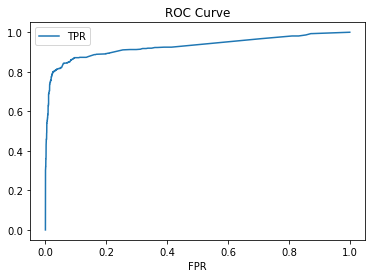

In [55]:
rf = RandomForestClassifier(featuresCol="features", labelCol="class", numTrees=10)
rf_model = rf.fit(train_data)

predictions = rf_model.transform(test_data)

#print(rf.explainParams())
num_trees = rf.getOrDefault("numTrees")
max_depth = rf.getOrDefault("maxDepth")
features_col = rf.getOrDefault("featuresCol")

print(f"Number of Trees: {num_trees}")
print(f"Max Depth: {max_depth}")
print(f"Features Column: {features_col}")

evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy = {accuracy}")

importances = rf_model.featureImportances
print(f"Feature Importances: {importances}")

evaluator = BinaryClassificationEvaluator(labelCol="class", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)

# Display ROC curve data (FPR, TPR)
roc_df = rf_model.summary.roc
roc_df.show()

# Print AUC value
print(f"Area Under the ROC Curve (AUC): {auc}")

# Optional: Plot the ROC curve (if using a Jupyter Notebook or a plotting environment)
roc_df.toPandas().plot(x='FPR', y='TPR', title='ROC Curve')

#### Logiistic Regression Classifier

+-----+----------+-----+
|class|prediction|count|
+-----+----------+-----+
|    1|       0.0|   96|
|    0|       0.0|  807|
|    1|       1.0|   28|
|    0|       1.0|   23|
+-----+----------+-----+

Accuracy: 0.8752620545073375
Precision: 0.8488880804137753
Recall: 0.8752620545073375
F1 Score: 0.851872481524628
+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|                 0.0| 0.00686106346483705|
|                 0.0|  0.0137221269296741|
|                 0.0| 0.02058319039451115|
|                 0.0|  0.0274442538593482|
|2.887669650591972...|0.032590051457975985|
|8.663008951775916E-4|0.036020583190394515|
|0.001443834825295...| 0.03945111492281304|
|0.001732601790355...|0.044596912521440824|
|0.002021368755414...| 0.04974271012006861|
|0.002598902685532...| 0.05317324185248713|
|0.003176436615651...| 0.05660377358490566|
|0.003753970545769564|0.0

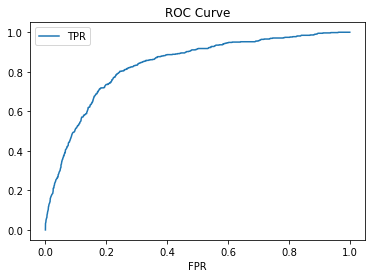

In [48]:
lr = LogisticRegression(featuresCol="features", labelCol="class")
lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)

confusion_matrix = predictions.groupBy("class", "prediction").count()
confusion_matrix.show()

evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Precision (weighted)
precision_evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)

# Recall (weighted)
recall_evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)

# F1 Score (weighted)
f1_evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

evaluator = BinaryClassificationEvaluator(labelCol="class", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)

#Display ROC curve data (FPR, TPR)
roc_df = lr_model.summary.roc
roc_df.show()

#Plot the ROC curve (Optional, you can visualize it if you're working in an environment that supports plotting)
roc_df.toPandas().plot(x='FPR', y='TPR', title='ROC Curve')

#Print AUC value
print(f"Area Under the ROC Curve (AUC): {auc}")

#### Support Vector Machine Classiffier

In [54]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

svm = LinearSVC(featuresCol="features", labelCol="class", maxIter=10)
svm_model = svm.fit(train_data)

#Make predictions
predictions = svm_model.transform(test_data)

confusion_matrix = predictions.groupBy("class", "prediction").count()
confusion_matrix.show()

# Calculate AUC (Area Under ROC) and ROC Curve
# Note: LinearSVC doesn't directly support probabilities, so AUC and ROC calculation is limited in Spark.
# But we can still calculate AUC using raw predictions.

# BinaryClassificationEvaluator for AUC calculation
evaluator = BinaryClassificationEvaluator(labelCol="class", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)

# Print AUC value
print(f"Area Under the ROC Curve (AUC): {auc}")

+-----+----------+-----+
|class|prediction|count|
+-----+----------+-----+
|    1|       0.0|  124|
|    0|       0.0|  830|
+-----+----------+-----+

Area Under the ROC Curve (AUC): 0.46945200155460576


#### K-Nearest Neighbors Classifier

In [88]:
''' Spark MLlib does not currently provide a built-in K-Nearest Neighbors (KNN) algorithm for classification. 
However, you can implement KNN using external libraries or custom approaches in PySpark. 
Typically, Spark ML includes algorithms like Decision Trees, Random Forests, 
and Logistic Regression, but KNN is not part of the default set
'''

' Spark MLlib does not currently provide a built-in K-Nearest Neighbors (KNN) algorithm for classification. \nHowever, you can implement KNN using external libraries or custom approaches in PySpark. \nTypically, Spark ML includes algorithms like Decision Trees, Random Forests, \nand Logistic Regression, but KNN is not part of the default set\n'

#### K-Nearest Neighbors Classifier using sklearn

              precision    recall  f1-score   support

           0       0.76      0.81      0.79        16
           1       0.25      0.20      0.22         5

    accuracy                           0.67        21
   macro avg       0.51      0.51      0.51        21
weighted avg       0.64      0.67      0.65        21



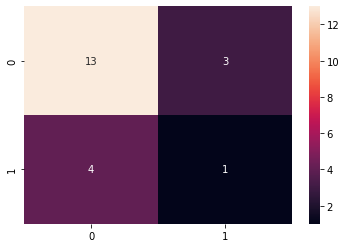

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


ky_df = pd.read_csv('23_kyphosis.csv')

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix


LabelEnconder_y = LabelEncoder()
ky_df['Kyphosis'] = LabelEnconder_y.fit_transform(ky_df['Kyphosis'])

ky_df.corr()
#plt.figure(figsize=(10,10))
#sns.heatmap(ky_df.corr(),annot=True)
#sns.pairplot(ky_df,hue = 'Kyphosis',vars = ['Age','Number','Start'])

X = ky_df.drop(['Kyphosis'],axis=1)
y = ky_df['Kyphosis']

X_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

knn_model = KNeighborsClassifier(n_neighbors = 3)
knn_model.fit(X_train,y_train)

y_predict_test = knn_model.predict(x_test)
cm = confusion_matrix(y_test,y_predict_test)
sns.heatmap(cm,annot=True)

print(classification_report(y_test,y_predict_test))

#### Naive Bayes Classifier

Accuracy: 0.639412997903564
+-----+----------+-----+
|class|prediction|count|
+-----+----------+-----+
|    1|       0.0|   45|
|    0|       0.0|  531|
|    1|       1.0|   79|
|    0|       1.0|  299|
+-----+----------+-----+

AUC: 0.6384279051690633


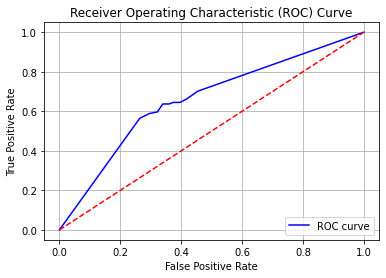

AUC: -0.6588952584531677


In [87]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import numpy as np
import matplotlib.pyplot as plt

nb = NaiveBayes(featuresCol="features", labelCol="class", modelType="multinomial")
nb_model = nb.fit(train_data)

#Make predictions
predictions = nb_model.transform(test_data)

#predictions.show()

accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")
                                
confusion_matrix = predictions.groupBy("class", "prediction").count()
confusion_matrix.show()

auc_evaluator = BinaryClassificationEvaluator(labelCol="class", rawPredictionCol="prediction", metricName="areaUnderROC")
auc = auc_evaluator.evaluate(predictions)
print(f"AUC: {auc}")

pred_probs = predictions.select("class", "probability").rdd.map(lambda row: (float(row[0]), float(row[1][1])))

#Prepare data for AUC calculation
pred_probs_df = spark.createDataFrame(pred_probs, ["class", "probability"])

#Calculate TPR and FPR at different thresholds
thresholds = np.arange(0.0, 1.1, 0.1)
tpr_list = []
fpr_list = []

for threshold in thresholds:
    tp = pred_probs_df.filter((col("probability") >= threshold) & (col("class") == 1)).count()
    fn = pred_probs_df.filter((col("probability") < threshold) & (col("class") == 1)).count()
    fp = pred_probs_df.filter((col("probability") >= threshold) & (col("class") == 0)).count()
    tn = pred_probs_df.filter((col("probability") < threshold) & (col("class") == 0)).count()

    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    tpr_list.append(tpr)
    fpr_list.append(fpr)

#Plot the ROC Curve
plt.figure()
plt.plot(fpr_list, tpr_list, color='blue', label='ROC curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

#Calculate AUC manually
auc = np.trapz(tpr_list, fpr_list)
print(f"AUC: {auc}")

#### XGBoost Classifier sklearn with GridSearch CV 

In [97]:
ky_df = pd.read_csv('22_UCI_Credit_Card.csv')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV


creditcard_df = pd.read_csv('22_UCI_Credit_Card.csv')

X_cat = creditcard_df[['SEX','EDUCATION','MARRIAGE']]

onehotencoder = OneHotEncoder()
X_cat = onehotencoder.fit_transform(X_cat).toarray()

X_cat = pd.DataFrame(X_cat)

X_numerical = creditcard_df[['LIMIT_BAL','AGE','PAY_0',
              'PAY_2','PAY_3','PAY_4','PAY_5','PAY_6',
              'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6'
                  ]]

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
#X = scaler.fit_transform(X_all)  -- XGBoost don't need #any scalling (Normalization or Standadization)

X = pd.concat([X_cat,X_numerical],axis =1)
y = creditcard_df['default.payment.next.month']

X_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

xgb_model = xgb.XGBClassifier(learniing_rate = 0.1, max_depth = 20, n_estimators = 500, use_label_encoder = False)
xgb_model.fit(X_train,y_train)

y_predict = xgb_model.predict(x_test)

print(f'Accuracy {accuracy_score(y_predict,y_test)}*100 % ')

cm = confusion_matrix(y_predict,y_test)
sns.heatmap(cm,annot = True, fmt = 'd')
print(classification_report(y_test,y_predict))

########### using grid search 

''' 
param_grid = {'gamma':[0.5,1,5],  #regularization parameter
              'subsample':[0.6,0.8,1.0], # % of rows taken to build eah tree
              'colsample_bytree':[0.6,0.8,1.0], # number off columns uuused by each tree
              'max_depth':[3,4,5]	 # depth of each tree
              }
'''

param_grid = {'learning_rate':[0.01,0.5,1], # regularization parameter
               'max_depth':[3,4,5]	 # depth of each tree
              }

xgb_model1 = xgb.XGBClassifier(learniing_rate = 0.01, max_depth = 20, n_estimators = 100, objective = 'binary:logistic')    

grid = GridSearchCV(xgb_model1,param_grid,refit = True, verbose = 4)
grid.fit(X_train,y_train)

y_predict_optim = grid.predict(x_test)
cm = confusion_matrix(y_predict_optim,y_test)
sns.heatmap(cm,annot = True,fmt = 'd')

print(classification_report(y_test,y_predict_optim))
